# Introdução à Ciência de Dados - UFPB
Professor: Yuri Malheiros

Projeto realizado como requisito parcial para conclusão da disciplina de ICD

Alunos: 

    Deivison Rodrigues Jordão
    Lucas Miranda de Aguiar
    Filipe de Medeiros Santos
    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [2]:
db = pd.read_csv("healthcare-dataset-stroke-data.csv")

db.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


# Limpeza e Transformação dos Dados

In [3]:
db.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [4]:
db["bmi"].isnull().sum()

201

In [5]:
db.dropna(inplace=True)

db.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

In [6]:
db.smoking_status.value_counts()

never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64

In [7]:
db.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
db = db.astype({"age": int})

db.age

0       67
2       80
3       49
4       79
5       81
        ..
5104    13
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 4909, dtype: int32

In [9]:
db.ever_married.unique()

array(['Yes', 'No'], dtype=object)

In [10]:
db.ever_married = db.ever_married.map({'Yes': 1, 'No': 0})

db.ever_married

0       1
2       1
3       1
4       1
5       1
       ..
5104    0
5106    1
5107    1
5108    1
5109    1
Name: ever_married, Length: 4909, dtype: int64

As colunas que passaram pelos processos de limpeza e transformação de seus dados foram as seguintes:

1. BMI: dado a existência de 201 linhas com dados faltantes, foi realizada a retirada das respectivas entradas;
2. Smoking Status: nesta coluna foi verificada a existência do valor categórico unknown, contudo, dada a quantidade de ocorrências tais entradas permaneceram inalteradas;
3. Age: os dados presentes nesta coluna tiveram seu tipo alterado de float para int, possibilitando maior eficiência nas análises posteriores;
4. Ever Married: dado que os únicos valores presentes são 'Yes' e 'No', logo, para facilitar a futura manipulação, as entradas foram substituídas para 1 e 0, respectivamente.

# Análise Exploratória

Algumas das colunas trabalhadas no dataset dispõem de dados categóricos, tornando inviável a aplicação de medidas de centralidade e dispersão a essas colunas. Desta forma, tais colunas serão exploradas com base na contagem da ocorrência dos valores categóricos e com o uso de gráficos para facilitar a visualização e entendimento dos dados.

In [11]:
# Medidas de centralidade e dispersão relacionadas ao dataset

def medidas(data):
    mean = np.mean(data)
    median = data.median()
    variance = np.var(data)
    std_deviation = np.std(data)
    dict_medidas = {"Média":mean,"Mediana":median,"Variância":variance,"Desvio Padrão":std_deviation}
    return pd.DataFrame(dict_medidas).T

## 1. Idade

### 1.1 Idade Geral

In [12]:
stroke_1 = db[db["stroke"] == 1]
stroke_0 = db[db["stroke"] == 0]

In [13]:
age = db[["age"]]

medidas(age)

,age
Média,42.85
Mediana,44.00
Variância,509.57
Desvio Padrão,22.57


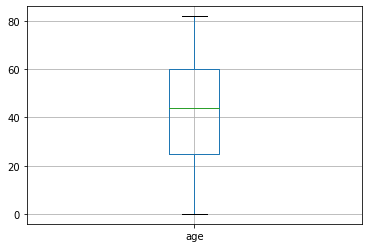

In [14]:
age.boxplot();

### 1.2 Idade dos indivíduos que sofreram AVC

In [15]:
age_1 = stroke_1[["age"]]
medidas(age_1)

,age
Média,67.71
Mediana,70.00
Variância,153.09
Desvio Padrão,12.37


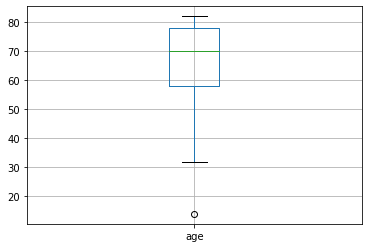

In [16]:
age_1.boxplot();

### 1.3 Idades dos indivíduos que não sofreram AVC

In [17]:
age_0 = stroke_0[["age"]]
medidas(age_0)

,age
Média,41.75
Mediana,43.00
Variância,496.72
Desvio Padrão,22.29


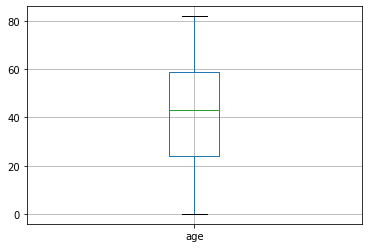

In [19]:
age_0.boxplot();

## 2. Nível de Glicose

### 2.1 Nível de Glicose Geral

In [20]:
glicose = db[["avg_glucose_level"]]
medidas(glicose)

,avg_glucose_level
Média,105.31
Mediana,91.68
Variância,1973.12
Desvio Padrão,44.42


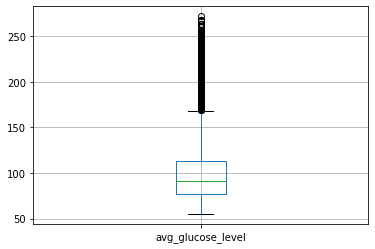

In [21]:
glicose.boxplot();

### 2.2 Nivel de glicose dos indivíduos que sofreram AVC

In [22]:
glicose_1 = stroke_1[["avg_glucose_level"]]
medidas(glicose_1)

,avg_glucose_level
Média,134.57
Mediana,106.58
Variância,3882.84
Desvio Padrão,62.31


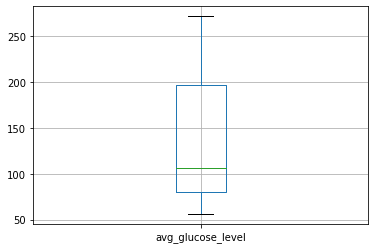

In [23]:
glicose_1.boxplot();

### 2.3 Nivel de glicose dos indivíduos que não sofreram AVC

In [24]:
glicose_0 = stroke_0[["avg_glucose_level"]]
medidas(glicose_0)

,avg_glucose_level
Média,104.00
Mediana,91.21
Variância,1848.42
Desvio Padrão,42.99


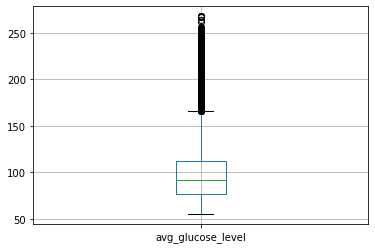

In [25]:
glicose_0.boxplot();

## 3. Com Relação ao Hábito de Fumar

In [26]:
smoke_status = stroke_1["smoking_status"].value_counts().T
smoke_status

never smoked       84
formerly smoked    57
smokes             39
Unknown            29
Name: smoking_status, dtype: int64

In [27]:
smoke_status = stroke_0["smoking_status"].value_counts().T
smoke_status

never smoked       1768
Unknown            1454
formerly smoked     780
smokes              698
Name: smoking_status, dtype: int64

## 4. Em Relação a Localidade

### 4.1 Pessoas que não sofreram AVC e sua localidade

In [31]:
residence_0 = db[db.stroke == 0]["Residence_type"].value_counts().to_frame()

residence_0

,Residence_type
Urban,2381
Rural,2319


Podemos ver que os moradores que não sofreram AVC estão bem distribuídos.

### 4.2 Pessoas que sofreram AVC e sua localidade

In [32]:
residence_1 = db[db.stroke == 1]["Residence_type"].value_counts().to_frame()

residence_1

,Residence_type
Urban,109
Rural,100


## 5. Em Relação ao IMC

### 5.1 IMC de pessoas que não tiveram AVC

In [33]:
bmi_0 = db[db.stroke == 0]["bmi"].to_frame()

bmi_0

,bmi
249,18.00
250,39.20
251,17.60
252,35.90
253,19.10
...,...
5104,18.60
5106,40.00
5107,30.60
5108,25.60


In [34]:
medidas(bmi_0)

,bmi
Média,28.82
Mediana,28.00
Variância,62.53
Desvio Padrão,7.91


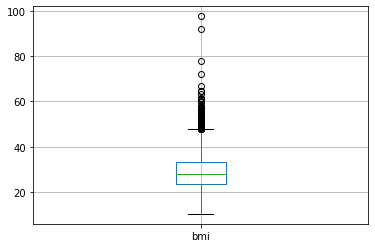

In [35]:
# Presença de vários outliers

bmi_0.boxplot();

### 5.2 IMC de pessoas que não tiveram AVC

In [36]:
bmi_1 = db[db.stroke == 1]["bmi"].to_frame()

bmi_1

,bmi
0,36.60
2,32.50
3,34.40
4,24.00
5,29.00
...,...
243,40.50
244,36.70
245,30.90
246,29.30


In [37]:
# Os dados não tem tanta variação, o que facilita o entendimento

medidas(bmi_1)

,bmi
Média,30.47
Mediana,29.70
Variância,39.87
Desvio Padrão,6.31


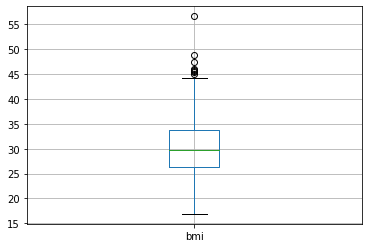

In [38]:
bmi_1.boxplot();

## 6. Em Relação às Doenças do Coração (heart disease)

In [40]:
heart_disease = db["heart_disease"].value_counts().to_frame()
heart_disease.rename({0: "No stroke", 1:"Stroke"}, axis='index', inplace=True)

heart_disease

,heart_disease
No stroke,4666
Stroke,243


In [42]:
heart_disease_0 = db[db.stroke == 0]
heart_disease_0 = heart_disease_0["heart_disease"].value_counts()
heart_disease_1 = db[db.stroke == 1]
heart_disease_1 = heart_disease_1["heart_disease"].value_counts()

heart = pd.DataFrame({"Heart Disease - V": heart_disease_1,
                     "Heart Disease - F": heart_disease_0})
heart = heart.rename({1: "Teve AVC", 0: "Não teve AVC"}, axis='index')

heart

,Heart Disease - V,Heart Disease - F
Não teve AVC,169,4497
Teve AVC,40,203


## 7. Em Relação à Coluna Gênero

In [43]:
gender = db["gender"]
gender.head()

0      Male
2      Male
3    Female
4    Female
5      Male
Name: gender, dtype: object

In [44]:
# Verificando a prevalência de gênero na base de dados

gender = gender.value_counts().to_frame()
gender

,gender
Female,2897
Male,2011
Other,1


In [45]:
# Incluindo a porcentagem de ocorrência por gênero

gender["gender_perc"] = gender["gender"] / gender["gender"].sum() * 100
gender

,gender,gender_perc
Female,2897,59.01
Male,2011,40.97
Other,1,0.02


In [46]:
gender_1 = stroke_1["gender"]
gender_1.head()

0      Male
2      Male
3    Female
4    Female
5      Male
Name: gender, dtype: object

In [47]:
gender["gender_1"] = gender_1.value_counts()
gender["gender_perc_1"] = gender["gender_1"] / gender["gender_1"].sum() * 100

gender

,gender,gender_perc,gender_1,gender_perc_1
Female,2897,59.01,120.00,57.42
Male,2011,40.97,89.00,42.58
Other,1,0.02,NaN,NaN


In [48]:
# Incluindo uma coluna com relação por gênero dos indivíduos que não tiveram AVC

gender['gender_0'] = gender['gender'] - gender['gender_1']
gender

,gender,gender_perc,gender_1,gender_perc_1,gender_0
Female,2897,59.01,120.00,57.42,2777.00
Male,2011,40.97,89.00,42.58,1922.00
Other,1,0.02,NaN,NaN,NaN


## 8. Em Relação ao Estado Civil

In [49]:
married = db["ever_married"].map({1: 'Casou', 0: 'Não casou'})
married.head()

0    Casou
2    Casou
3    Casou
4    Casou
5    Casou
Name: ever_married, dtype: object

In [50]:
# Verificando a prevalência de pessoas que já foram casadas na base de dados

married = married.value_counts().to_frame()
married

,ever_married
Casou,3204
Não casou,1705


In [51]:
# Incluindo a porcentagem de ocorrência

married["married_perc"] = married["ever_married"] / married["ever_married"].sum() * 100
married

,ever_married,married_perc
Casou,3204,65.27
Não casou,1705,34.73


In [52]:
married_1 = stroke_1["ever_married"].map({1:'Casou', 0:'Não casou'})
married_1.head()

0    Casou
2    Casou
3    Casou
4    Casou
5    Casou
Name: ever_married, dtype: object

In [53]:
# Verificando a prevalência de pessoas que já foram casadas nas entradas em que houveram a ocorrência de AVC
# Incluindo a porcentagem no dataframe

married["ever_married_1"] = married_1.value_counts()
married["married_perc_1"] = married["ever_married_1"] / married["ever_married_1"].sum() * 100

married

,ever_married,married_perc,ever_married_1,married_perc_1
Casou,3204,65.27,186,89.00
Não casou,1705,34.73,23,11.00


## 9. Tipo de Trabalho 

In [54]:
work = db["work_type"]
work.head()

0          Private
2          Private
3          Private
4    Self-employed
5          Private
Name: work_type, dtype: object

In [55]:
work = work.value_counts().to_frame()
work

,work_type
Private,2811
Self-employed,775
children,671
Govt_job,630
Never_worked,22


In [56]:
# Incluindo a porcentagem de ocorrência por tipo de trabalho

work["work_perc"] = work["work_type"] / work["work_type"].sum() * 100
work

,work_type,work_perc
Private,2811,57.26
Self-employed,775,15.79
children,671,13.67
Govt_job,630,12.83
Never_worked,22,0.45


In [57]:
work_1 = stroke_1["work_type"]
work_1.head()

0          Private
2          Private
3          Private
4    Self-employed
5          Private
Name: work_type, dtype: object

In [58]:
# Verificando a prevalência pelo tipo de trabalho das entradas em que houveram a ocorrência de AVC
# Incluindo a porcentagem no dataframe

work["work_type_1"] = work_1.value_counts()
work["work_perc_1"] = work["work_type_1"] / work["work_type_1"].sum() * 100

work

,work_type,work_perc,work_type_1,work_perc_1
Private,2811,57.26,127.00,60.77
Self-employed,775,15.79,53.00,25.36
children,671,13.67,1.00,0.48
Govt_job,630,12.83,28.00,13.40
Never_worked,22,0.45,NaN,NaN


# Vizualização dos Dados

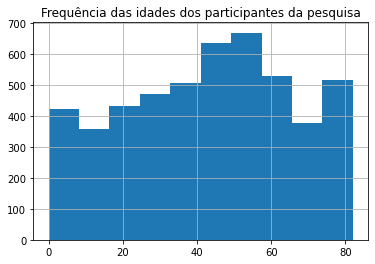

In [59]:
age.hist();
plt.title("Frequência das idades dos participantes da pesquisa");

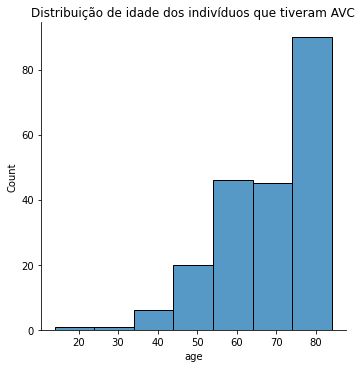

In [60]:
sns.displot(age_1,x="age",binwidth = 10)
plt.title("Distribuição de idade dos indivíduos que tiveram AVC");

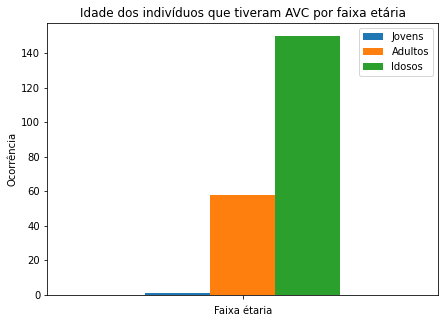

In [61]:
age_1_count = age_1.value_counts().reset_index()

age_1_count_jovens = age_1_count[age_1_count.age < 19]
age_1_count_adulto = age_1_count[age_1_count.age < 60].sum() - age_1_count_jovens
age_1_count_idoso = age_1_count[age_1_count.age > 59].sum()

age_group = pd.DataFrame([{"Jovens": age_1_count_jovens.iloc[0,1],
                           "Adultos": age_1_count_adulto.iloc[0,1],
                           "Idosos":age_1_count_idoso[0]}])
age_group = age_group.rename({0 :""}, axis='index')

age_group.plot.bar(rot=0, title='Idade dos indivíduos que tiveram AVC por faixa etária',
                   figsize=(7,5), ylabel='Ocorrência' , xlabel='Faixa étaria');

Nos gráficos acima verificamos as ocorrências de AVC conforme a idade, ficando nítido que, com o aumento da idade se intensifica os casos de AVC, demonstrando assim uma correlação entre idade e o risco de AVC, sendo, portanto, os idosos os mais afetados.

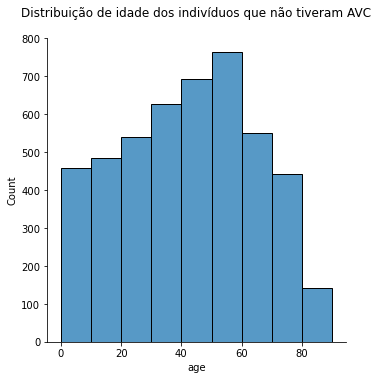

In [62]:
sns.displot(age_0,x="age",binwidth = 10);
plt.title("Distribuição de idade dos indivíduos que não tiveram AVC\n");

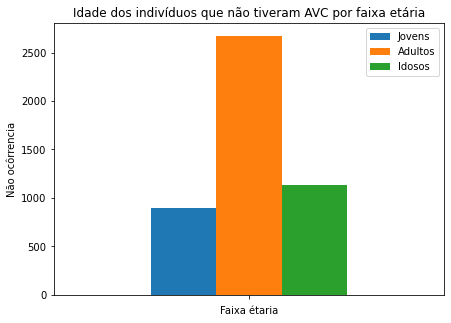

In [63]:
age_0_count = age_0.value_counts().reset_index()

age_0_count_jovens = age_0_count[age_0_count.age < 19].sum()
age_0_count_adulto = age_0_count[age_0_count.age < 60].sum() - age_0_count_jovens
age_0_count_idoso = age_0_count[age_0_count.age > 59].sum()

age_0_group = pd.DataFrame([{"Jovens": age_0_count_jovens[0],
                             "Adultos": age_0_count_adulto[0],
                             "Idosos": age_0_count_idoso[0]}])
age_0_group = age_0_group.rename({0 :""}, axis='index')

age_0_group.plot.bar(rot=0, title='Idade dos indivíduos que não tiveram AVC por faixa etária',
                     figsize=(7,5), ylabel='Não ocôrrencia' , xlabel='Faixa étaria');

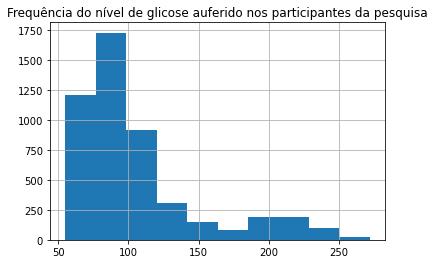

In [64]:
glicose.hist();
plt.title("Frequência do nível de glicose auferido nos participantes da pesquisa");

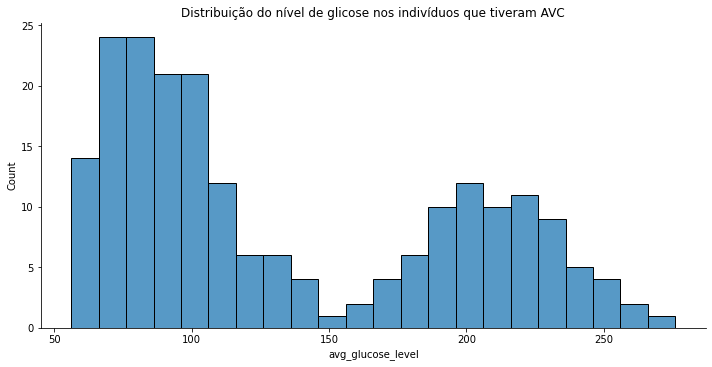

In [65]:
sns.displot(glicose_1,x="avg_glucose_level",binwidth = 10, height=5, aspect=2)
plt.title("Distribuição do nível de glicose nos indivíduos que tiveram AVC");

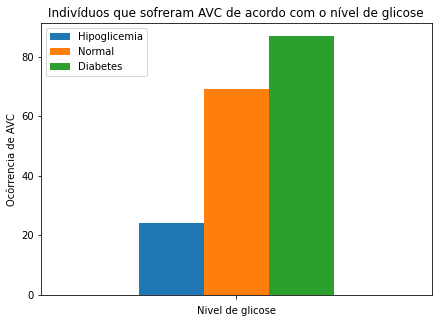

In [69]:
glicose_1_count = glicose_1.value_counts().reset_index()

glicose_1_count_baixa = glicose_1_count[glicose_1_count.avg_glucose_level < 71].sum()
glicose_1_count_normal = glicose_1_count[glicose_1_count.avg_glucose_level < 100].sum() - glicose_1_count_baixa
glicose_1_count_alta = glicose_1_count[glicose_1_count.avg_glucose_level > 125].sum()

df_glicose_1_count = pd.DataFrame([{"Hipoglicemia": glicose_1_count_baixa[0],
                                    "Normal": glicose_1_count_normal[0],
                                    "Diabetes":glicose_1_count_alta[0]}])
df_glicose_1_count = df_glicose_1_count.rename({0 :""}, axis='index')

df_glicose_1_count.plot.bar(rot=0, title='Indivíduos que sofreram AVC de acordo com o nível de glicose',
                            figsize=(7,5), ylabel='Ocôrrencia de AVC' , xlabel='Nivel de glicose');

Ao analisar os gráficos acima, nota-se uma tendência ao aumento nos casos de AVC com relação ao nivel de glicose. Pode-se inferir, pelos gráficos acima, que, indíviduos que sofrem de diabetes têm uma forte tendência a também sofrer de AVC.

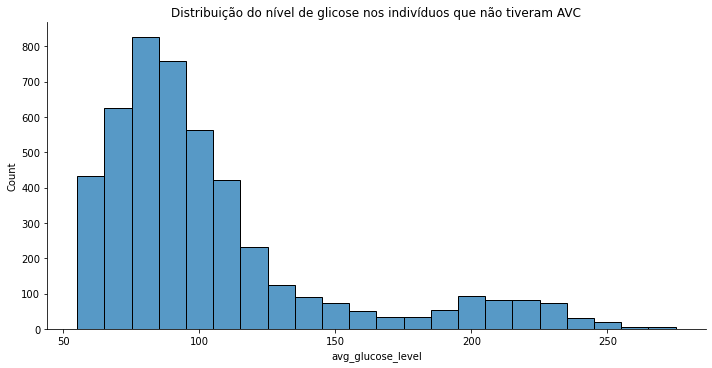

In [67]:
sns.displot(glicose_0,x="avg_glucose_level",binwidth = 10, aspect=2)
plt.title("Distribuição do nível de glicose nos indivíduos que não tiveram AVC");

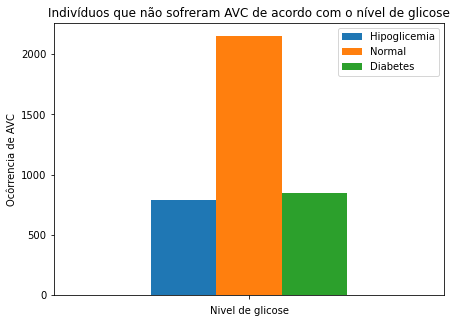

In [70]:
glicose_0_count = glicose_0.value_counts().reset_index()

glicose_0_count_baixa = glicose_0_count[glicose_0_count.avg_glucose_level < 71].sum()
glicose_0_count_normal = glicose_0_count[glicose_0_count.avg_glucose_level < 100].sum() - glicose_0_count_baixa
glicose_0_count_alta = glicose_0_count[glicose_0_count.avg_glucose_level > 125].sum()

df_glicose_0_count = pd.DataFrame([{"Hipoglicemia": glicose_0_count_baixa[0],
                                    "Normal": glicose_0_count_normal[0],
                                    "Diabetes":glicose_0_count_alta[0]}])
df_glicose_0_count = df_glicose_0_count.rename({0 :""}, axis='index')

df_glicose_0_count.plot.bar(rot=0, title='Indivíduos que não sofreram AVC de acordo com o nível de glicose',
                            figsize=(7,5), ylabel='Ocôrrencia de AVC' , xlabel='Nivel de glicose');

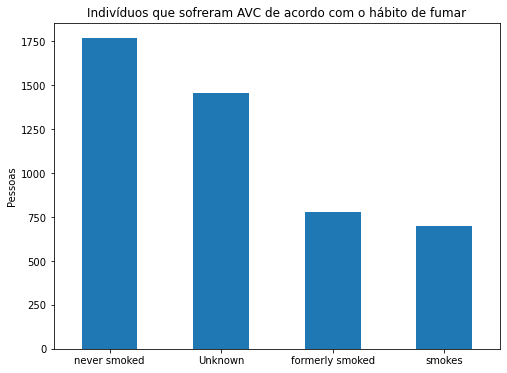

In [71]:
smoke_status.plot.bar(rot=0, ylabel="Pessoas", title="Indivíduos que sofreram AVC de acordo com o hábito de fumar",
                      figsize=(8,6));

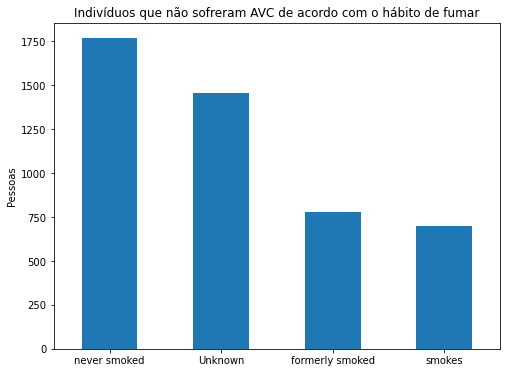

In [72]:
smoke_status.plot.bar(rot=0, ylabel ="Pessoas",title = "Indivíduos que não sofreram AVC de acordo com o hábito de fumar",
                      figsize=(8,6));

Dados demonstram que pessoas que fumam tem mais chances de ter AVC do que as que não tem esse hábito.

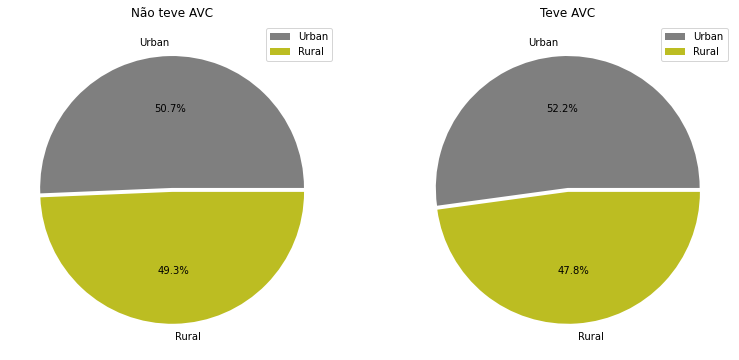

In [73]:
# Pessoas que moram na cidade tem uma porcentagem maior de ter avc

residence = pd.DataFrame({'Não teve AVC': residence_0["Residence_type"], 'Teve AVC': residence_1["Residence_type"]})
residence = residence.plot.pie(subplots= True, figsize= (13,7), explode=(0, 0.03),
                               autopct='%1.1f%%',colors= ['tab:gray','tab:olive'])

residence[0].set_ylabel("")
residence[1].set_ylabel("")
residence[0].set_title("Não teve AVC")
residence[1].set_title("Teve AVC");

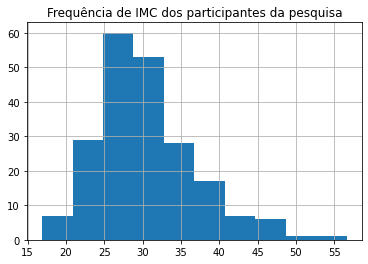

In [74]:
bmi_1.hist()
plt.title("Frequência de IMC dos participantes da pesquisa");

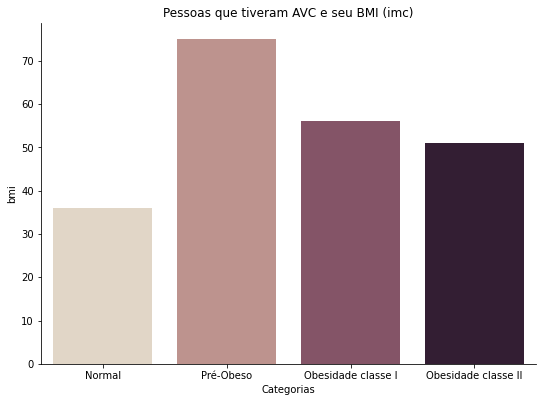

In [75]:
bmi_group = bmi_1["bmi"].value_counts()

bmi_group_1 = bmi_group[bmi_group.index < 25].sum()
bmi_group_2 = bmi_group[bmi_group.index < 30].sum() - bmi_group_1
bmi_group_3 = bmi_group[bmi_group.index < 35].sum() -  (bmi_group_2 + bmi_group_1)
bmi_group_4 = bmi_group[bmi_group.index > 34].sum()

bmi_group_df = pd.DataFrame([{"Normal": bmi_group_1, "Pré-Obeso": bmi_group_2, 
                          "Obesidade classe I": bmi_group_3, "Obesidade classe II": bmi_group_4}])
bmi_group_df = bmi_group_df.rename({0 :"BMI"}, axis='columns')
bmi_group_df = sns.catplot(data=bmi_group_df,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
bmi_group_df.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que tiveram AVC e seu BMI (imc)');

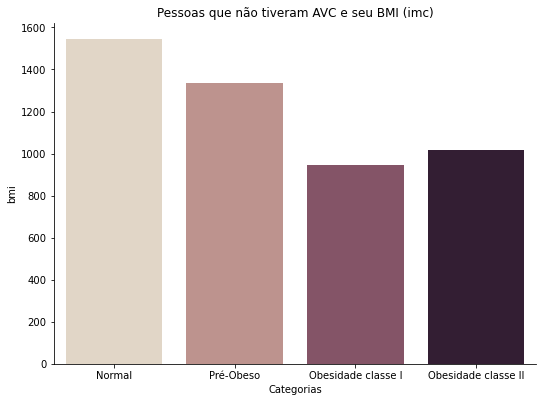

In [76]:
bmi_group_0 = bmi_0["bmi"].value_counts().to_frame()

bmi_group_0 = bmi_group_0.dropna()
bmi1 = bmi_group_0[bmi_group_0.index < 25].sum()
bmi2 = bmi_group_0[bmi_group_0.index < 30].sum() - bmi1
bmi3 = bmi_group_0[bmi_group_0.index < 35].sum() -  (bmi2 + bmi1)
bmi4 = bmi_group_0[bmi_group_0.index > 34].sum()

df_bmi_group_0 = pd.DataFrame([{"Normal": bmi1[0], "Pré-Obeso": bmi2[0],
                          "Obesidade classe I":bmi3[0], "Obesidade classe II": bmi4[0]}])

ax = sns.catplot(data=df_bmi_group_0,palette="ch:.25", kind="bar", height=5.27, aspect=11.7/8.27)
ax.set(xlabel='Categorias', ylabel='bmi', title='Pessoas que não tiveram AVC e seu BMI (imc)');

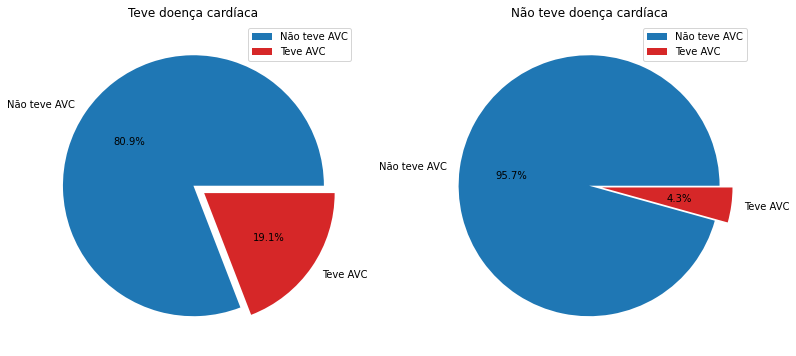

In [77]:
# Observamos que existe um número elevado de pessoas sem problemas do coração, o que prejudica a análise
# Trabalhemos, portanto com percentual

ax_heart = heart.plot.pie(subplots=True, figsize= (13,6), ylabel='', 
                          explode=(0, 0.1), autopct='%1.1f%%', colors=['tab:blue','tab:red']);

ax_heart[0].set_title("Teve doença cardíaca")
ax_heart[1].set_title("Não teve doença cardíaca");

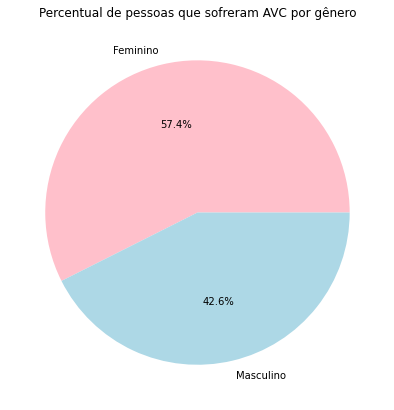

In [78]:
gender["gender_perc_1"].dropna().plot.pie(title="Percentual de pessoas que sofreram AVC por gênero",
                                 ylabel='', colors=['pink', 'lightblue'], autopct='%1.1f%%',
                                 labels=["Feminino", "Masculino", ""], figsize=(13,7));

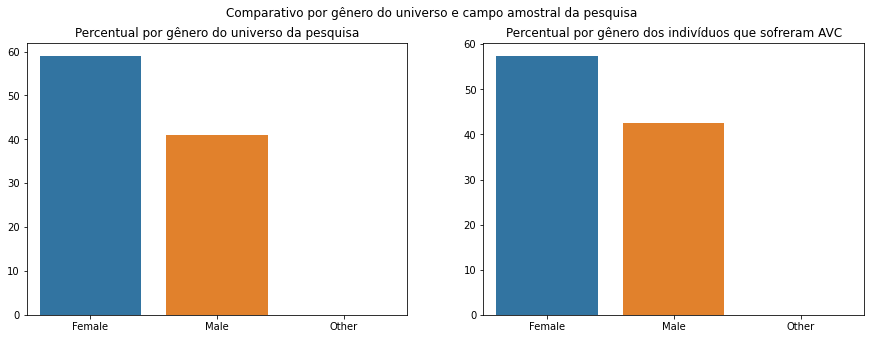

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Comparativo por gênero do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=gender.index, y='gender_perc', data=gender)
axes[0].set_title('Percentual por gênero do universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=gender.index, y='gender_perc_1', data=gender)
axes[1].set_title('Percentual por gênero dos indivíduos que sofreram AVC')
axes[1].set_ylabel('');

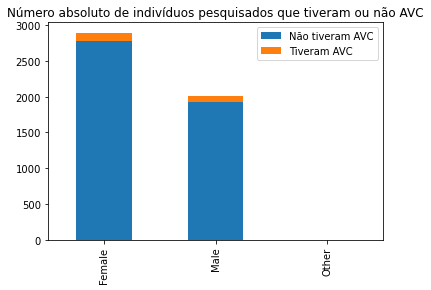

In [80]:
ax = gender[['gender_0', 'gender_1']].plot.bar(stacked=True)

ax.legend(["Não tiveram AVC", "Tiveram AVC"])
plt.title("Número absoluto de indivíduos pesquisados que tiveram ou não AVC");

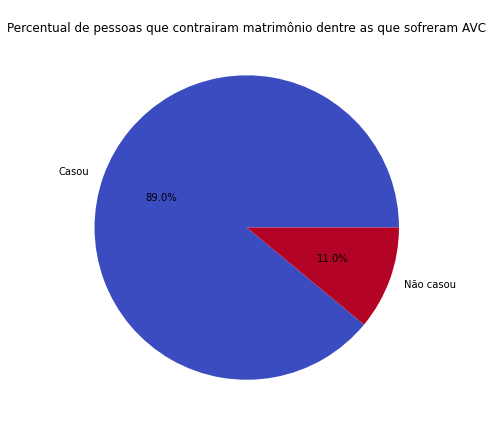

In [81]:
married["married_perc_1"].plot.pie(title="\nPercentual de pessoas que contrairam matrimônio dentre as que sofreram AVC",
                                   ylabel='', colormap="coolwarm", figsize=(10,7),autopct='%1.1f%%');

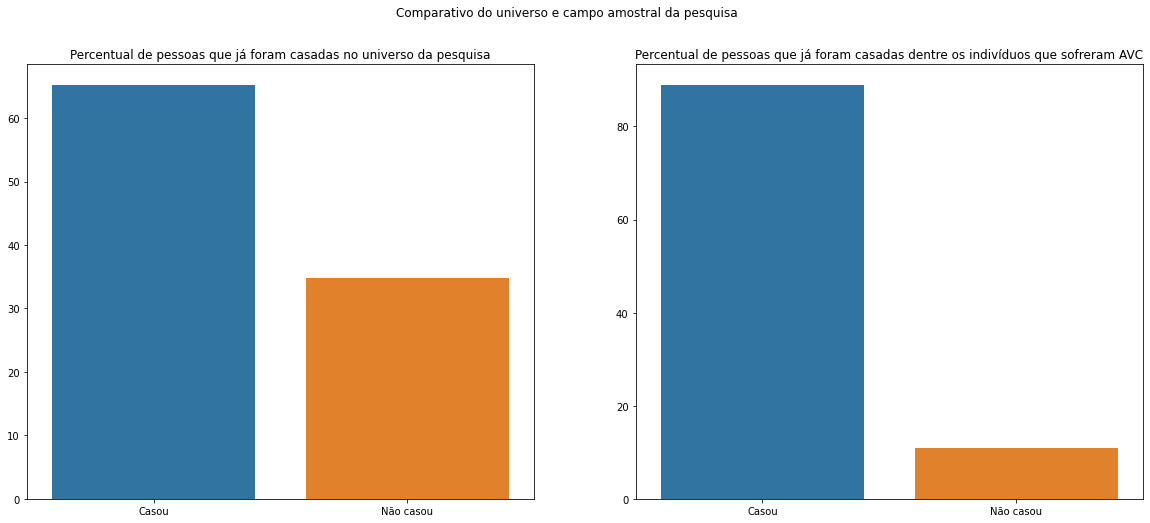

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=married.index, y='married_perc', data=married)
axes[0].set_title('Percentual de pessoas que já foram casadas no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=married.index, y='married_perc_1', data=married)
axes[1].set_title('Percentual de pessoas que já foram casadas dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');

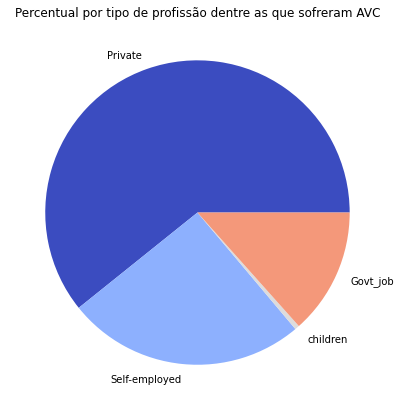

In [84]:
work["work_perc_1"].plot.pie(title="Percentual por tipo de profissão dentre as que sofreram AVC", ylabel='',
                             colormap="coolwarm", figsize=(10,7));

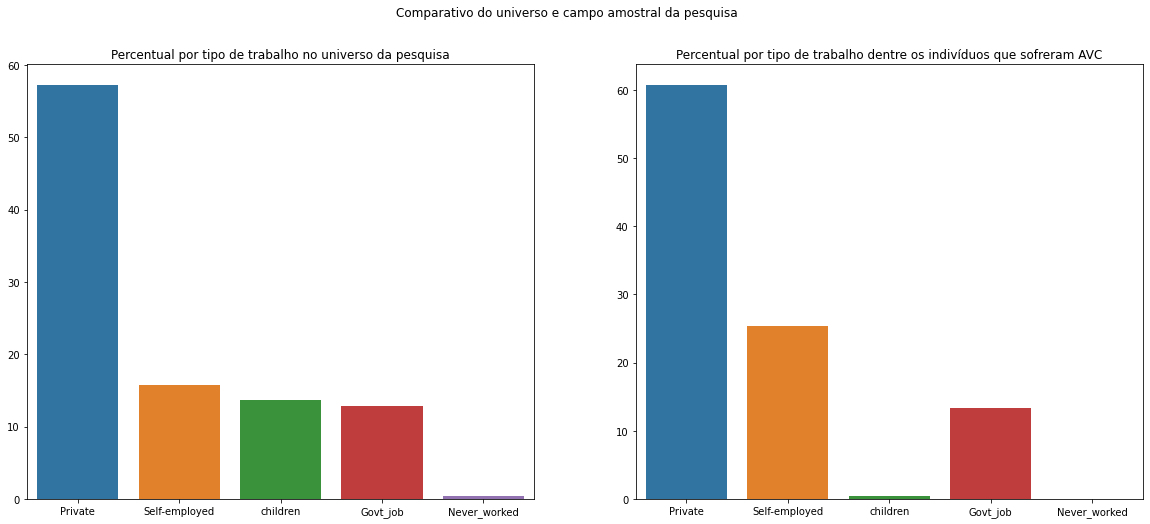

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparativo do universo e campo amostral da pesquisa')

sns.barplot(ax=axes[0], x=work.index, y='work_perc', data=work)
axes[0].set_title('Percentual por tipo de trabalho no universo da pesquisa')
axes[0].set_ylabel('')

sns.barplot(ax=axes[1], x=work.index, y='work_perc_1', data=work)
axes[1].set_title('Percentual por tipo de trabalho dentre os indivíduos que sofreram AVC')
axes[1].set_ylabel('');